episode: 0   score: 14.0   memory length: 15   epsilon: 0.9851045463620021
episode: 1   score: 26.0   memory length: 42   epsilon: 0.9588496310845509
episode: 2   score: 25.0   memory length: 68   epsilon: 0.9342286880693633
episode: 3   score: 46.0   memory length: 115   epsilon: 0.8913148576343527
episode: 4   score: 37.0   memory length: 153   epsilon: 0.8580640336044925
episode: 5   score: 14.0   memory length: 168   epsilon: 0.8452827805735033
episode: 6   score: 19.0   memory length: 188   epsilon: 0.8285367691502946
episode: 7   score: 9.0   memory length: 198   epsilon: 0.8202885863627752
episode: 8   score: 34.0   memory length: 233   epsilon: 0.7920612314455105
episode: 9   score: 20.0   memory length: 254   epsilon: 0.7755932297267324
episode: 10   score: 11.0   memory length: 266   epsilon: 0.766337129875968
episode: 11   score: 21.0   memory length: 288   epsilon: 0.7496535623221505
episode: 12   score: 47.0   memory length: 336   epsilon: 0.7145029791340722
episode: 13   

episode: 105   score: 8.0   memory length: 2000   epsilon: 0.05461460345792028
episode: 106   score: 9.0   memory length: 2000   epsilon: 0.0540709085381996
episode: 107   score: 86.0   memory length: 2000   epsilon: 0.04956340590351174
episode: 108   score: 31.0   memory length: 2000   epsilon: 0.048001716301798183
episode: 109   score: 24.0   memory length: 2000   epsilon: 0.04681596410987613
episode: 110   score: 22.0   memory length: 2000   epsilon: 0.0457509588761811
episode: 111   score: 27.0   memory length: 2000   epsilon: 0.04448707694223361
episode: 112   score: 40.0   memory length: 2000   epsilon: 0.04269911643052126
episode: 113   score: 25.0   memory length: 2000   epsilon: 0.041602706234017746
episode: 114   score: 28.0   memory length: 2000   epsilon: 0.04041296741885872
episode: 115   score: 20.0   memory length: 2000   epsilon: 0.039572728318025406
episode: 116   score: 14.0   memory length: 2000   epsilon: 0.03898327457803516
episode: 117   score: 11.0   memory lengt

episode: 207   score: 100.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 208   score: 91.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 209   score: 101.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 210   score: 64.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 211   score: 77.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 212   score: 191.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 213   score: 75.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 214   score: 142.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 215   score: 48.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 216   score: 62.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 217   score: 161.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 218   score: 68.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 219   score: 9

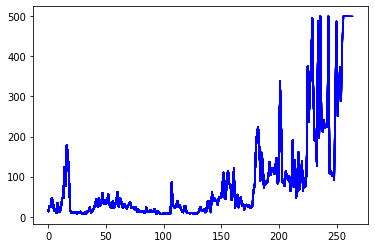

In [9]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

EPISODES = 500


# DRQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and replay memory & target q network
class DRQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DRQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./cartpole_drqn.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(LSTM(32, input_shape=(self.state_size, 2)))
        model.add(Dense(self.action_size))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size, 2))
        update_target = np.zeros((batch_size, self.state_size, 2))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        # and do the model fit!      
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)


if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v1')

    # Number of past state to use
    number_of_past_state = 4

    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    expanded_state_size = state_size * number_of_past_state
    action_size = env.action_space.n

    agent = DRQNAgent(expanded_state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()

        # expand the state with past states and initialize
        expanded_state = np.zeros(expanded_state_size)
        expanded_next_state = np.zeros(expanded_state_size)
        for h in range(state_size):
            expanded_state[(h + 1) * number_of_past_state - 1] = state[h]

        # reshape states for LSTM input without embedding layer
        reshaped_state = np.zeros((1, expanded_state_size, 2))
        for i in range(expanded_state_size):
            for j in range(2):
                reshaped_state[0, i, j] = expanded_state[i]

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(reshaped_state)
            next_state, reward, done, info = env.step(action)

            # update the expanded next state with next state values
            for h in range(state_size):
                expanded_next_state[(h + 1) * number_of_past_state - 1] = next_state[h]

            # reshape expanded next state for LSTM input without embedding layer
            reshaped_next_state = np.zeros((1, expanded_state_size, 2))
            for i in range(expanded_state_size):
                for j in range(2):
                    reshaped_next_state[0, i, j] = expanded_next_state[i]

            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(reshaped_state, action, reward, reshaped_next_state, done)

            # every time step do the training
            agent.train_model()
            score += reward
            reshaped_state = reshaped_next_state

            # Shifting past state elements to the left by one
            expanded_next_state = np.roll(expanded_next_state, -1)

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./cartpole_drqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training
            # revised to exit cleanly on Jupiter notebook
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                #sys.exit()
                env.close()
                break

        # save the model
        if e % 50 == 0:
            agent.model.save_weights("./cartpole_drqn.h5")